In [479]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! git checkout error_bars
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
importlib.reload(vae_models)
importlib.reload(models)
importlib.reload(my_utils)
importlib.reload(utils)
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


Cloning into 'hetvae'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 460 (delta 4), reused 1 (delta 0), pack-reused 448
Receiving objects: 100% (460/460), 20.20 MiB | 8.81 MiB/s, done.
Resolving deltas: 100% (295/295), done.
Branch 'error_bars' set up to track remote branch 'error_bars' from 'origin'.
Switched to a new branch 'error_bars'


##Pick your poison:

In [535]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#-------------------------------
agn_file = '/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv'
agn_df = pd.read_csv(agn_file)
# handle formatting for new AGN
bands = agn_df['Filter'].unique()
lcs = []
for lc_df in agn_df.groupby('Filter'):
  lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
  lcs.append(lc)


In [ ]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')[:4]
lcs,max_len = my_utils.file_to_np(*(lc_files*100))
lcs = lcs[:64]

## Data augmentation

In [536]:
new_samples = (lcs * 10).copy()
for lc in new_samples:
  lc = my_utils.resample_lc(lc)
lcs.extend(new_samples) 

lcs is now a python list of numpy array lcs 


In [539]:
lcs, starts, max_len = my_utils.zero_start(lcs)
lcs = my_utils.handle_dups(lcs)
union_tp = my_utils.union_timepoints(lcs)
print(len(union_tp))
lcs = my_utils.include_union_tp(lcs, max_len)
lcs.shape

2423


(55, 621, 3)

In [540]:

# lets think about removing outliers


#----------------------------------------------------------------------------------------------------------
# NORMALIZING
#----------------------------------------------------------------------------------------------------------
std_time = np.std(union_tp)
#std_flux = np.std(lcs[:,:,1].flatten())
#mean_flux = np.mean(lcs[:,:,1].flatten())
union_tp = union_tp / std_time
lcs[:,:,0] = lcs[:,:,0] / std_time

# normalize flux for light curves individually
for lc in lcs:
    lc[:,1] = lc[:,1] / np.std(lc[:,1])
    # how are we going to normalize error bars?
    lc[:,2] = lc[:,2] / np.std(lc[:,1])

# ----------------------------------------------------------------------------------------------------------
lcs = lcs.astype(np.float32)
union_tp = union_tp.astype(np.float32)
union_tp = torch.tensor(union_tp)

#-----------------------------------------------------------------------------------------------------------
#MASKS
#-----------------------------------------------------------------------------------------------------------

smask, rmask = my_utils.make_masks(lcs, frac=0.5)
lcs = np.concatenate((lcs, smask[:,:,np.newaxis], rmask[:,:,np.newaxis]), axis=-1)

In [543]:
train_loader = torch.utils.data.DataLoader(lcs, batch_size=8)
dim = 1


## Setting up arguments

In [544]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [545]:
# num heads?
args = Namespace(batch_size=8, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=256, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.000001, mixing='concat', mse_weight=0.0, n=256, net='hetvae', 
                 niters=1000, norm=False, normalize_input='znorm', num_ref_points=128, rec_hidden=128, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=1024)

In [546]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [547]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Generating Synthetic Data**

In [314]:

# dataset class that loads agn by folder you give it? agn object, agn.addLC('').addLC('')
# kl negative? negative losses in general???
# fixing visualization
# different sequence sizes, some drastically shorter... how to make this not matter? does it? --> standardize how many points we take in ?
# what is their normalization=True doing? ->dividing by the sum of the masks? 
# 

## **Loading HeTVAE model**

In [561]:
net = models.load_network(args, dim, union_tp) # dim = 1
params = list(net.parameters())
optimizer = optim.Adam(params, lr=.00001)
# definitly want a decaying error rate...
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)


## **Training**

In [562]:
def train(net, optimizer,epoch, train_loader):
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:]

          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              train_batch[:, :, 1:2] * subsampled_mask, subsampled_mask
          ), -1) 

    # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, 0], # context_x, times
              context_y,             # context_y
              train_batch[:, :, 0], # target_x, same times? 
              torch.cat((            # flux values with only recon_mask values showing
                  train_batch[:, :, 1:2] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae, # 1? 
              beta=1,
              # optional, will be zero if not set
              error_bars = 0.#train_batch[:,:,2:3],    # ? 
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
          
          # if train_loss < 1:
          #   break
      
      # if train_loss <= 5:
      #   return
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
      
      
        # no test data yet
    #       for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
    #           utils.evaluate_hetvae(
    #               net,
    #               dim,
    #               loader,
    #               0.5,
    #               shuffle=False,
    #               k_iwae=num_samples,
    #               model_name=args.net,
    #           )


In [582]:
for epoch in range(201, 300+1):#args.niters + 1):
    train(net, optimizer, epoch, train_loader)
    scheduler.step()

Iter: 300, train loss: 0.6521, avg nll: -0.8654, avg kl: 1.5175, mse: 0.161153, mae: 0.233803


In [581]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.00000001

1e-07


In [ ]:
torch.save(net, 'weights.pt')
# we'll download saved weights locally, then reupload them 
net = torch.load('weights.pt')

## **Vizualization with increasing number of observations**

In [583]:

def viz(test_loader, net, k_iwae=1, n_max=10, ):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for _ in range(3):
            for i, batch in enumerate(test_loader):
                
                batch_len = batch.shape[0]
                batch = batch.to(device)
                subsampled_mask = batch[:,:,3:4]
                seqlen = batch.size(1)
                context_y = torch.cat((batch[:, :, 1:2] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, 1:2]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, 0].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.99, axis=0)
    quantile1 = np.quantile(preds, 0.01, axis=0)
    print(preds.shape)
    print("pay attention", quantile1.shape)
    print(preds)
    
    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12.5, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()


In [ ]:

# torch.cuda.empty_cache()
# pred_mean, pred_std = [],[]
# masks = []
# targets = []
# tp = []
# k_iwae = 10
# np.random.seed(0)
# with torch.no_grad():
#   batch = next(iter(train_loader)).to(device)
#   print(batch.shape)
#   batch_len = len(batch)
#   subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device)
#   seqlen = batch.size(1)
#   context_y = torch.cat((batch[:,:,1:2] * subsampled_mask, subsampled_mask), -1)
#   context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
#   px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
#   pred = px.mean.cpu().numpy()
#   pred_std = torch.exp(0.5 * px.logvar).cpu().numpy() # e^(0.5 * logvar)

# points = batch.cpu().numpy()


torch.Size([8, 147, 3])


(10, 48, 621, 1) (10, 48, 621, 1) (48, 621, 1) (48, 621, 1) (48, 621)
(50, 48, 621, 1)
pay attention (48, 621, 1)
[[[[17.88595837]
   [16.89071111]
   [17.31072612]
   ...
   [18.4614716 ]
   [16.70881726]
   [18.07946001]]

  [[ 4.06220724]
   [ 4.0895969 ]
   [ 4.07675087]
   ...
   [ 3.94492454]
   [ 4.53890397]
   [ 4.15609732]]

  [[ 5.07638008]
   [ 5.03331504]
   [ 5.06059989]
   ...
   [ 4.85325126]
   [ 4.87997768]
   [ 4.87343907]]

  ...

  [[ 2.73239834]
   [ 2.66340981]
   [ 2.76356242]
   ...
   [ 2.89773713]
   [ 2.81202625]
   [ 2.66997621]]

  [[ 3.84431842]
   [ 3.81882242]
   [ 3.92442866]
   ...
   [ 3.60686522]
   [ 3.71041789]
   [ 3.5972536 ]]

  [[16.30188605]
   [16.72408627]
   [16.32172713]
   ...
   [16.83167445]
   [17.85166851]
   [17.44120641]]]


 [[[17.3361606 ]
   [17.71735181]
   [15.49618759]
   ...
   [17.36652889]
   [17.52474039]
   [17.93242719]]

  [[ 3.86816722]
   [ 3.93210909]
   [ 3.8796782 ]
   ...
   [ 4.31364056]
   [ 4.15316759]
   [ 4.0

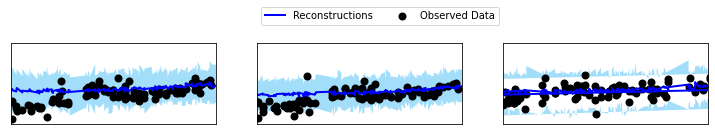

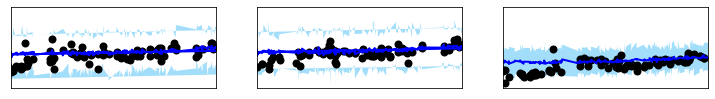

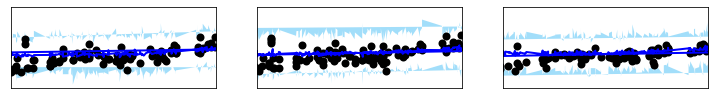

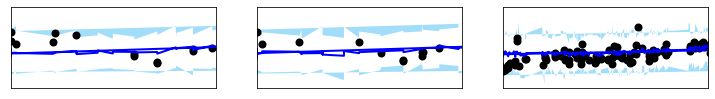

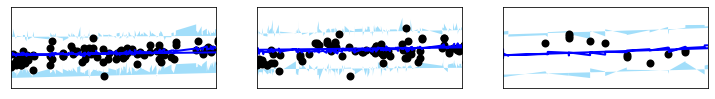

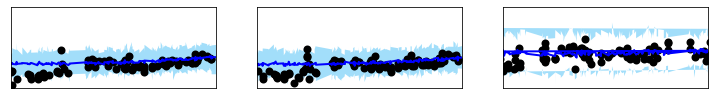

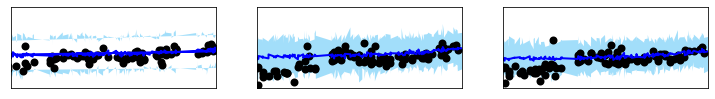

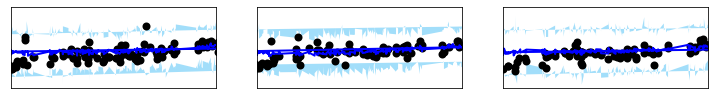

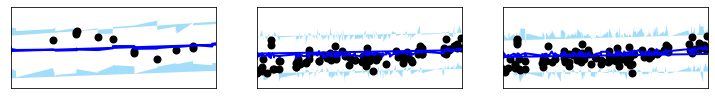

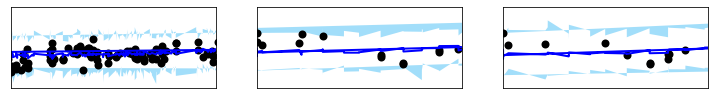

In [584]:
viz(train_loader, net, k_iwae=10)

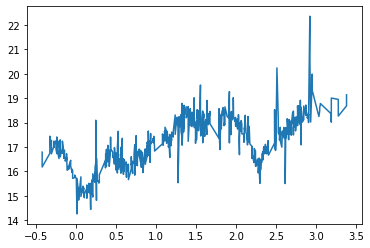

In [560]:
plt.plot(lcs[0,:,0], lcs[0,:,1])